In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from tqdm import tqdm

# Load Model

In [3]:
from phoneme_model import load_phoneme_model

In [4]:
pretrained_path = "/home/ay/data/best-epoch=17-val-per=0.312388.ckpt"
# pretrained_path="/home/ay/data/DATA/1-model_save/01-phoneme/phoneme_recongition/version_0/checkpoints/best-epoch=28-val-per=0.278449.ckpt"
pretrained_path="/home/ay/data/DATA/1-model_save/01-phoneme/phoneme_recongition/version_4/checkpoints/best-epoch=57-val-per=0.268208.ckpt"
# pretrained_path="/home/ay/data/DATA/1-model_save/01-phoneme/phoneme_recongition/version_5/checkpoints/best-epoch=49-val-per=0.273750.ckpt"


In [5]:
model = load_phoneme_model(pretrained_path=pretrained_path).cuda(1)

/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2

# Load dataset

In [6]:
import sys

sys.path.append("../")

In [7]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Sampler, default_collate, random_split

try:
    from .data.tools import WaveDataset
except ImportError:
    from data.tools import WaveDataset

In [8]:
from ay2.datasets.audio import MLAAD_AudioDs

In [9]:
def load_MLAAD_subset(root_path:str = "/home/ay/data/0-原始数据集/MLADD", language:str='en', n_audios=1000):

    ds = MLAAD_AudioDs(root_path=root_path)
    if isinstance(language, str):
        data = ds.data.query(f'language == {language}').sample(n_audios)
    else:
        data = ds.data.query(f'language in {language}').sample(n_audios)
        
    _ds = WaveDataset(
        data,
        sample_rate=16000,
        normalize=True,
        transform=None,
        dtype="tensor",
    )
    print(f"read {len(_ds)} audios for the language {language} in {root_path}")
    return _ds

In [27]:
_ds = load_MLAAD_subset(language=['en', 'es', 'de'], n_audios=3000)
_ds = load_MLAAD_subset(language=['de'], n_audios=1000)

read 3000 audios for the language ['en', 'es', 'de'] in /home/ay/data/0-原始数据集/MLADD
read 1000 audios for the language ['de'] in /home/ay/data/0-原始数据集/MLADD


# Compute weights

In [20]:
from ay2.visualization.tsne import plot_tSNE_res, tSNE_cluster

In [21]:
def get_weights(logits):
    predict_ids = torch.argmax(logits, dim=-1)

    numbers = predict_ids
    # Initialize weights list
    weights = [0] * len(numbers)
    # Identify sequences and assign weights
    current_sequence_length = 1
    for i in range(1, len(numbers)):
        if numbers[i] == numbers[i - 1]:
            current_sequence_length += 1
        else:
            for j in range(i - current_sequence_length, i):
                weights[j] = current_sequence_length
            current_sequence_length = 1

    # Handle the last sequence
    for j in range(len(numbers) - current_sequence_length, len(numbers)):
        weights[j] = current_sequence_length
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
    weights_tensor = weights_tensor / torch.sum(weights_tensor)
    return weights_tensor

In [31]:
def get_weighted_hidden_state(model, x):
    model_res = model.model.model(x, output_hidden_states=True)
    logits = model_res.logits[0]
    hidden_state = model_res.hidden_states[-1][0]
    # print(logits.shape, hidden_state.shape)

    weights = get_weights(logits).to(x.device)
    _h = hidden_state * weights[:, None]
    _h = torch.sum(_h, dim=0)
    # print(weights.shape, _h.shape)
    return _h

In [34]:
def get_hidden_states_labels(model, _ds):
    hidden_states = []
    labels = []
    for i in tqdm(range(len(_ds))):
        item = _ds[i]
        x = item["audio"].cuda(1)
    
        # if x.size(1) > 64000:
        # x = x[:, :64000]
        with torch.no_grad():
            # hidden_state = model.model.model(x, output_hidden_states=True).hidden_states[-1][0]
            # hidden_state = torch.mean(hidden_state, dim=0)
            hidden_state = get_weighted_hidden_state(model, x)
        hidden_states.append(hidden_state)
        labels.append(item["label"])
    
    hidden_states = torch.stack(hidden_states).detach().cpu()
    return hidden_states, labels

In [25]:
def get_subpart(_index, label):
    if labels[_index] == label:
        return True
    else:
        return False

read 1000 audios for the language ['en'] in /home/ay/data/0-原始数据集/MLADD


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 28.63it/s]


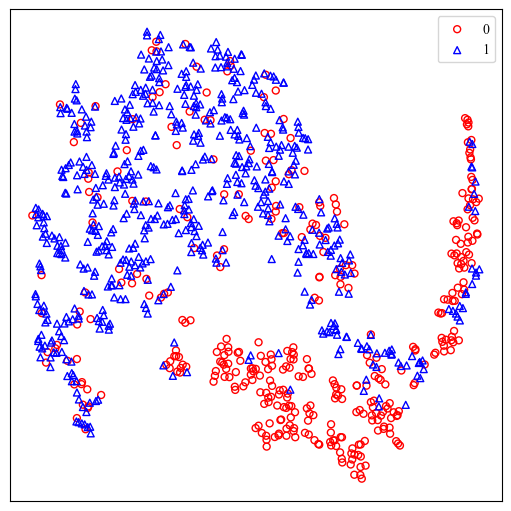

read 1000 audios for the language ['de'] in /home/ay/data/0-原始数据集/MLADD


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.48it/s]


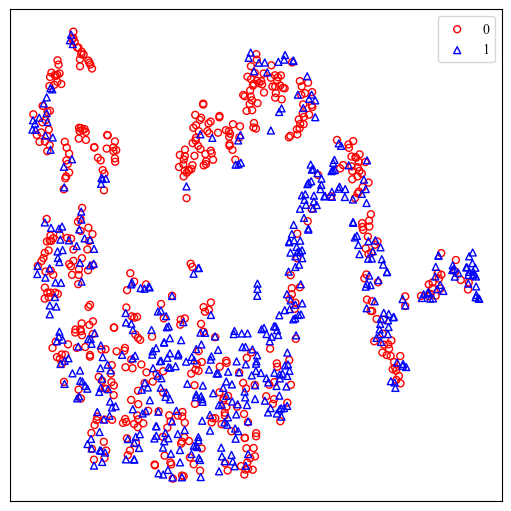

read 1000 audios for the language ['es'] in /home/ay/data/0-原始数据集/MLADD


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.94it/s]


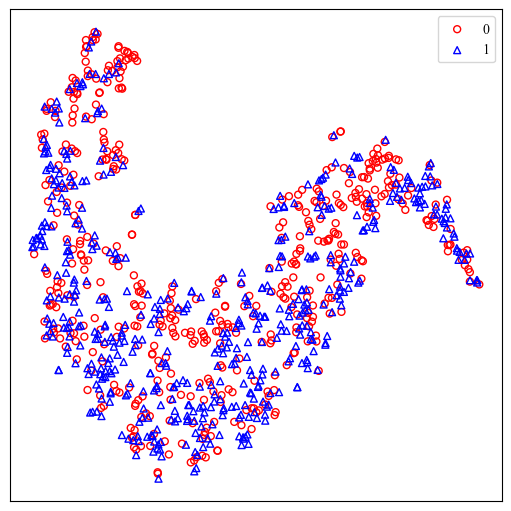

In [37]:
for language in ['en', 'de', 'es']:
    _ds = load_MLAAD_subset(language=[language], n_audios=1000)
    hidden_states, labels = get_hidden_states_labels(model, _ds)

    result = tSNE_cluster(hidden_states)
    plot_tSNE_res(
        result, point_labels=[0, 1], index_func=get_subpart, markers=["o", "^"], colors=["red", "blue"]
    )